Reading /Users/shivshah/eeg_lab/sub-002_task-FaceRecognition_eeg.fdt
Reading 0 ... 747749  =      0.000 ...  2990.996 secs...


/var/folders/4l/rnx8d51d32l3qk890tvt6zrc0000gp/T/ipykernel_69381/857509330.py:10: RuntimeWarning: Unknown types found, setting as type EEG:
ekg: ['EEG063', 'EEG064']
heog: ['EEG061']
veog: ['EEG062']
  raw = mne.io.read_raw_eeglab('./sub-002_task-FaceRecognition_eeg.set', preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/4l/rnx8d51d32l3qk890tvt6zrc0000gp/T/ipykernel_69381/857509330.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab('./sub-002_task-FaceRecognition_eeg.set', preload=True)


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Used Annotations descriptions: [np.str_('boundary'), np.str_('famous_new'), np.str_('famous_second_early'), np.str_('famous_second_late'), np.str_('left_nonsym'), np.str_('right_sym'), np.str_('scrambled_new'), np.str_('scrambled_second_early'), np.str_('scrambled_second_late'), np.str_('unfamiliar_new'), np.str_('unfamiliar_second_early'), np.str_('unfamiliar_second_late')]
Event IDs: {np.str_('boundary'): 1, np.str_('famous_new'): 2, np.str_('famous_second_early'): 3, np.str_('famous_second_late'): 4, np.str_('left_nonsym'): 5, np.str_('right_sym'): 6, np.str_('scrambled_new'): 7, np.str_('scrambled_second_early'): 8, np.str_('scrambled_second_late'): 9, np.str_('unfamiliar_new'): 10, np.str_('unfamiliar_second_early'): 11, np.str_('unfamiliar_second_late'): 12}

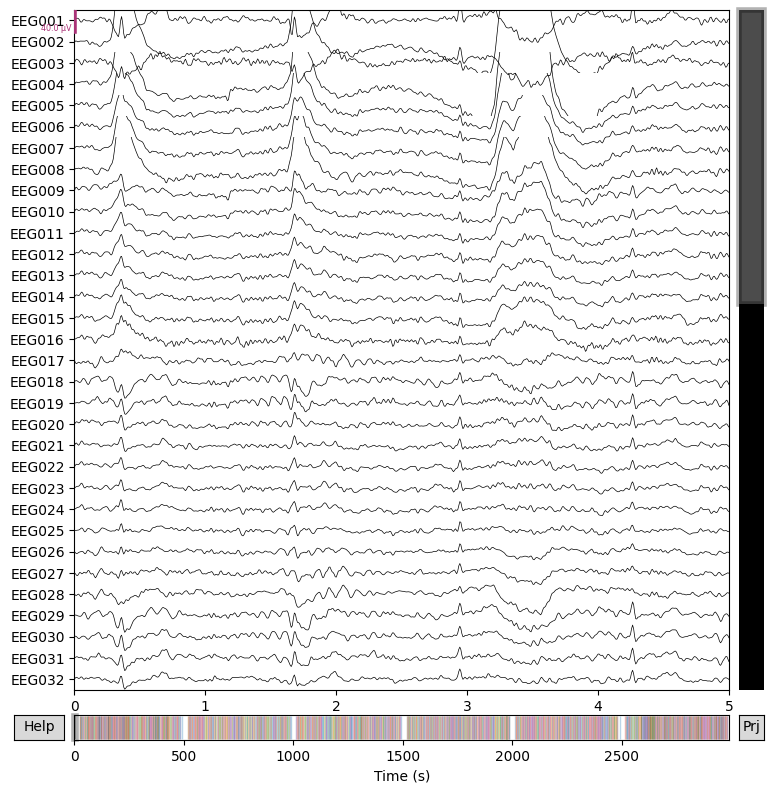

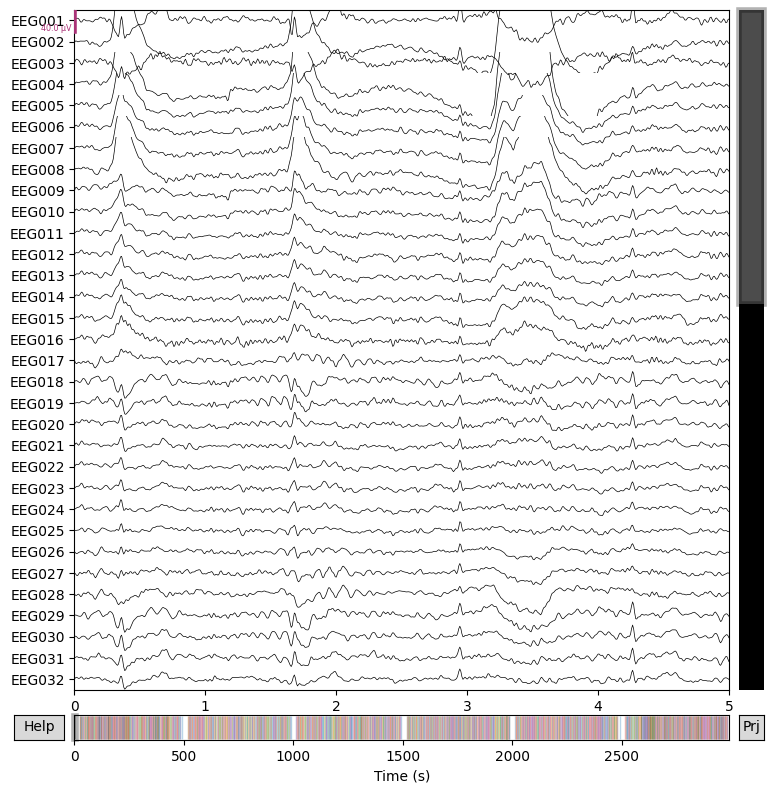

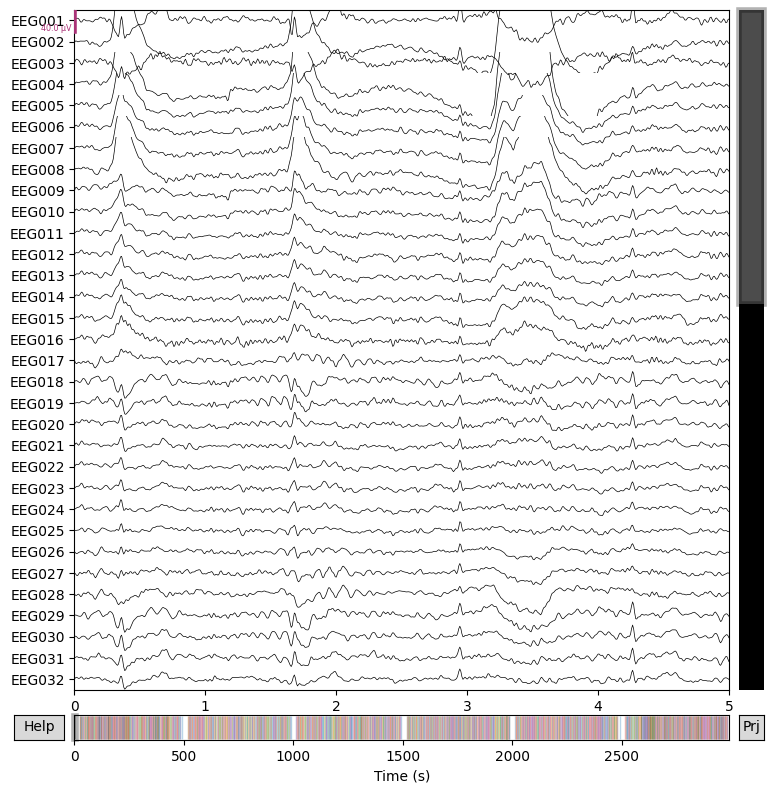

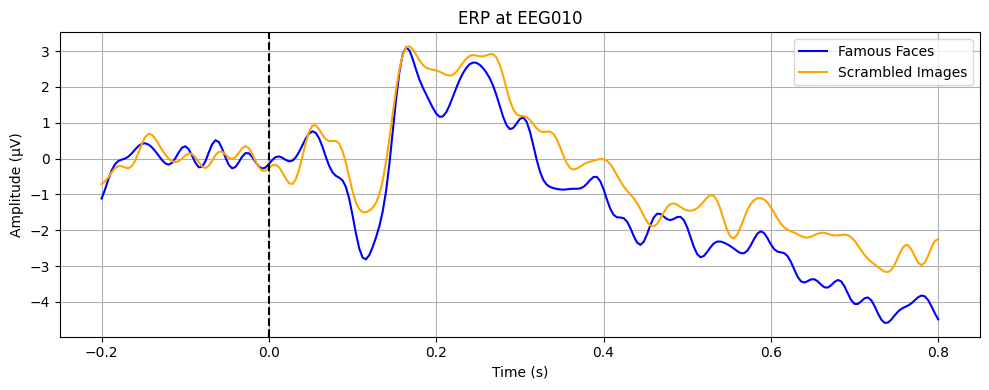

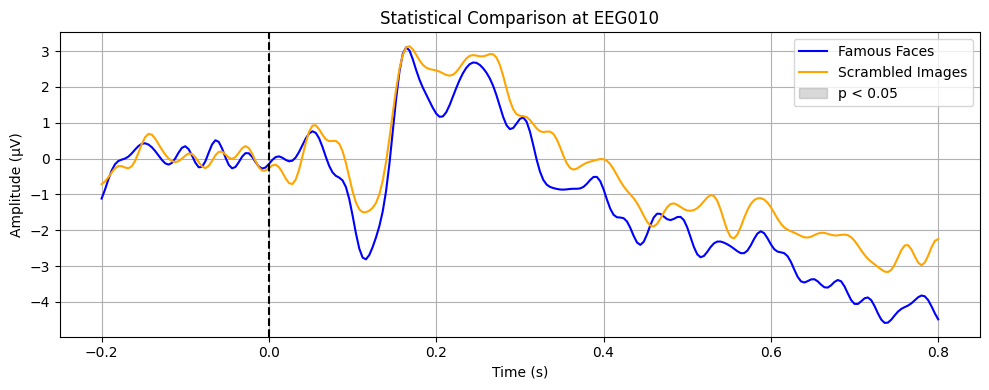

In [7]:
# ✅ Step 1: Import libraries
import mne
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

# ---

# ✅ Step 2: Load the EEG data
raw = mne.io.read_raw_eeglab('./sub-002_task-FaceRecognition_eeg.set', preload=True)
raw.filter(1., 30., fir_design='firwin')  # Bandpass filter
raw.set_eeg_reference('average', projection=True)
raw.plot(title='Raw EEG Data', duration=5, n_channels=32, show=False)

# ---

# ✅ Step 3: Extract and annotate events
events, event_id = mne.events_from_annotations(raw)
print("Event IDs:", event_id)

# Select two categories for comparison
event_id = {
    'famous_new': event_id['famous_new'],
    'scrambled_new': event_id['scrambled_new']
}

# Epoching: Create epochs time-locked to stimulus presentation
epochs = mne.Epochs(raw, events, event_id=event_id, tmin=-0.2, tmax=0.8,
                    baseline=(None, 0), preload=True)

# Separate by condition
epochs_face = epochs['famous_new']
epochs_scrambled = epochs['scrambled_new']

# ---

# ✅ Step 4: Visualize ERPs at one channel (e.g., EEG010)
electrode = 'EEG010'

# Get data for each condition at that electrode
face_data = epochs_face.copy().pick_channels([electrode]).get_data()[:, 0, :]
scrambled_data = epochs_scrambled.copy().pick_channels([electrode]).get_data()[:, 0, :]

# Time vector (in seconds)
times = epochs.times

# Compute average ERP
erp_face = face_data.mean(axis=0)
erp_scrambled = scrambled_data.mean(axis=0)

# Plot ERPs
plt.figure(figsize=(10, 4))
plt.plot(times, erp_face * 1e6, label='Famous Faces', color='blue')
plt.plot(times, erp_scrambled * 1e6, label='Scrambled Images', color='orange')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.title(f'ERP at {electrode}')
plt.legend()
plt.axvline(0, color='black', linestyle='--')
plt.grid(True)
plt.tight_layout()
plt.show()

# ---

# ✅ Step 5: Statistical comparison (t-test at each time point)
t_vals, p_vals = ttest_rel(face_data, scrambled_data, axis=0)
sig_mask = p_vals < 0.05

# Plot with significance mask
plt.figure(figsize=(10, 4))
plt.plot(times, erp_face * 1e6, label='Famous Faces', color='blue')
plt.plot(times, erp_scrambled * 1e6, label='Scrambled Images', color='orange')
plt.fill_between(times, -10, 10, where=sig_mask, color='gray', alpha=0.3, label='p < 0.05')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.title(f'Statistical Comparison at {electrode}')
plt.legend()
plt.axvline(0, color='black', linestyle='--')
plt.grid(True)
plt.tight_layout()
plt.show()
